# LiveEO Data Science Challenge - Thibault Latrace

This

## I. Data exploration

Import of the libraries and the tools that will be used during the whole study :

In [1]:
import rasterio
import matplotlib.pyplot as plt
import folium
import numpy as np
import pandas as pd
import os
import scikitplot as skplt

from pyproj import Proj, Transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import cross_val_score 

Exploration of the labeled dataset metadata :

In [2]:
dataset = rasterio.open('resources/rasterize_on_sentinel_2_labelled_17SLD.tif')

print(dataset.meta)

print(dataset.meta['crs'])

# Outputs :

# TODO : refacto cette partie pour afficher correctement le code

# crs : EPSG 32617 --> referencing the UTM zone 17N
# shape : (10980, 10980)
# dtype : uint32
# number of bands : 2 --> only the first one will be used

{'driver': 'GTiff', 'dtype': 'uint32', 'nodata': 4294967295.0, 'width': 10980, 'height': 10980, 'count': 2, 'crs': CRS.from_epsg(32617), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 4400040.0)}
EPSG:32617


Let's see what area this picture delimits :

In [3]:
# use of the metada affine transformation matrix to spot the spatial position of the upper left corner in the crs 32617
previous_upper_left_corner_coords = dataset.transform * (0, 0)
previous_lower_right_corner_coords = dataset.transform * (dataset.width, dataset.height)

# transformer implementation to switch the crs to the classic WGS 84 CRS
utm_zone_17N_crs = 32617
WGS84_crs = 4326
transformer = Transformer.from_crs(utm_zone_17N_crs, WGS84_crs)

# top left and bottom right corner coordinates conversion
corners_coords = list()
for point in transformer.itransform([previous_upper_left_corner_coords, previous_lower_right_corner_coords]):
    coords = '{} {}'.format(*point)
    x = coords.split(' ')[0]
    y = coords.split(' ')[1]
    corners_coords.append((x, y))
new_upper_left_corner_coords = corners_coords[0]
new_lower_right_corner_coords = corners_coords[1]

print(new_upper_left_corner_coords, new_lower_right_corner_coords)

('39.72680595264749', '-83.33363283055375') ('38.75625435854099', '-82.03810488537515')


Visualization of the dataset :

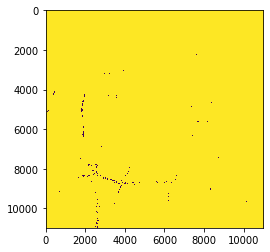

In [4]:
labeled_band = dataset.read(1)

plt.imshow(labeled_band)

We can see that the majority of the data are nodata values !

Let's watch on an interactive map to what area corresponds the image : 

In [5]:
# creation of a folium interactive map
m = folium.Map(list(new_lower_right_corner_coords),zoom_start = 7, tiles='Stamen Terrain')
folium.Marker(list(new_upper_left_corner_coords)).add_to(m)
folium.Marker(list(new_lower_right_corner_coords)).add_to(m)
m

Transformation of the labelled band into a DataFrame in order to ease the manipulation. We also drop the label nodata values : 

In [6]:
reduced_label_band_df = pd.DataFrame(labeled_band.ravel()).replace(4294967295, pd.NA)
previous_label_band_size = reduced_label_band_df.shape

# this is the key step where we drop nodata values
reduced_label_band_df = reduced_label_band_df.dropna().rename(columns = {0: 'label'})
new_label_band_size = reduced_label_band_df.shape

reduced_label_band_df['label'] = reduced_label_band_df['label'].astype(int)

print('Reduction coefficient :' + str(previous_label_band_size[0]/new_label_band_size[0]))

Reduction coefficient :369.37415553737696


We just divided by almost 400 the size of our dataset !!!
It will be a lot more convenient to work with this size-reduced data for the machine learning process

Concatenation of the labeled layer and the 15 bands of the dataset, by projecting the bands where the labeled data is not null : 

In [7]:
bands_folder_path = 'S2_17SLD_2019-09-15_masked_warped'

band_paths = [os.path.join(bands_folder_path, my_file)
              for my_file in os.listdir(bands_folder_path)
              if os.path.isfile(os.path.join(bands_folder_path, my_file))]

bands_names = list()
final_dataset_df = reduced_label_band_df
for band_number in range(len(band_paths)):
    with rasterio.open(band_paths[band_number]) as band_dataset:
        band = band_dataset.read(1)
        ravelled_band = band.ravel()
        band_df = pd.DataFrame(ravelled_band).rename(columns = {0: '{}'.format(band_paths[band_number].split('\\')[1].split('_')[2])})
        bands_names.append(band_paths[band_number].split('\\')[1].split('_')[2])
        
        final_dataset_df = pd.concat([final_dataset_df, band_df.reindex(final_dataset_df.index)], axis = 1)
        band_dataset.close()
final_dataset_df = final_dataset_df.reset_index().rename(columns = {'index': 'previous_index'})
print(final_dataset_df)
print(bands_names)

        previous_index  label  AOT   B01   B02   B03   B04   B05   B06   B07  \
0               350913      3   69   360   391   640   735  1274  1954  2300   
1               354514      0   70  2347  2302  2674  2778  3944  4185  3975   
2               354515      0   70  2347  4328  4272  4220  3944  4185  3975   
3               354516      0   70  3878  4316  4564  4728  5445  5242  5489   
4               354517      0   70  3878  4460  4400  4792  5445  5242  5489   
...                ...    ...  ...   ...   ...   ...   ...   ...   ...   ...   
326386       120332403      4   70   264   236   466   263   702  2844  3513   
326387       120409747      3   70   589   322   462   473  1077  1570  1836   
326388       120420734      3   70   760   713   939   991  1288  1654  1832   
326389       120464649      3   70   768   517   576   686  1084  1603  1857   
326390       120519538      3   70   442   329   530   438   949  1697  1891   

         B08   B09   B11   B12   B8A  S

Reindexing and add of a label mapping in order to improve readibility of the dataset :

I used the [European Space Agency documentation](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial) to translate the titles of the TIF files provided into scientific features :

In [8]:
# translation of the columns title with a mapping dictionnary
bands_meaning = ['AOT',
                 'coastal_aerosol',
                 'blue',
                 'green',
                 'red',
                 'IR_705nm',
                 'IR_740nm',
                 'IR_783nm',
                 'IR_842nm',
                 'water_vapour',
                 'SWIR_1610nm',
                 'SWIR_2190nm',
                 'IR_865nm',
                 'SCL',
                 'WVP']
bands_meaning_mapping = {bands_names[i]: bands_meaning[i] for i in range(len(bands_names))}
final_dataset_df = final_dataset_df.rename(columns = bands_meaning_mapping)

# TODO : peut-être mettre colonne coordonées (x, y) : par exemple on pourrait transformer l'index en multiIndex

#insertion of the label_meaning column
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
label_meaning_df = final_dataset_df['label'].replace(label_mapping)

pd.concat([final_dataset_df, label_meaning_df], axis = 1).head()

,previous_index,label,AOT,coastal_aerosol,blue,green,red,IR_705nm,IR_740nm,IR_783nm,IR_842nm,water_vapour,SWIR_1610nm,SWIR_2190nm,IR_865nm,SCL,WVP,label
0,350913,3,69,360,391,640,735,1274,1954,2300,2374,2620,2853,1803,2566,4,2728,single tree
1,354514,0,70,2347,2302,2674,2778,3944,4185,3975,2784,2979,3758,2708,3884,9,2241,urban
2,354515,0,70,2347,4328,4272,4220,3944,4185,3975,4220,2979,3758,2708,3884,9,2241,urban
3,354516,0,70,3878,4316,4564,4728,5445,5242,5489,4500,3836,4589,2917,5310,9,2518,urban
4,354517,0,70,3878,4460,4400,4792,5445,5242,5489,4600,3836,4589,2917,5310,9,2518,urban


Storing of the final dataset into a csv :

In [9]:
final_dataset_df.to_csv('final_dataset.csv',  index = False)

**CHECKPOINT** : To this point, we don't need to execute the code above anymore : the dataset is definitly stored in the file 'final_dataset.csv'. However, if we restart the kernel, we will still need to execute the first bloc of imports before continuing to execute the Model Training part.

## 2. Classifier Training

We split the dataset into train and test data : 80% for the training data and 20% for the testing one.

Furthermore, as long as we want to predict a class (survived or not), we will use a Classifier model. It chose here to use a RandomForestClassifier.

In [10]:
final_dataset_df = pd.read_csv('final_dataset.csv')

# split of the dataset
prediction_target = final_dataset_df['label']
X1 = final_dataset_df.drop(columns = ['label', 'previous_index'])
train_data1, test_data1, train_prediction_target1, test_prediction_target1 = train_test_split(X1, prediction_target, train_size = 0.8, random_state = 1)

# classifier training
model1 = RandomForestClassifier(random_state = 1)
model1.fit(train_data1, train_prediction_target)
predictions1 = model.predict(test_data1)

# evaluation of the classifier
confusion_mtrx_1 = confusion_matrix(test_prediction_target1, predictions1)
class_report_1 = classification_report(test_prediction_target1, predictions1, zero_division = True)

NameError: name 'train_prediction_target' is not defined

In [ ]:
# smooth plot of the confusion matrix
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
skplt.metrics.plot_confusion_matrix(
    test_prediction_target1.replace(label_mapping), 
    pd.DataFrame(predictions1).replace(label_mapping),
    figsize = (10, 10),
    title = 'Label confusion matrix',
    x_tick_rotation = 45,
    cmap = 'Greens')

print(class_report_1)

Improvement of the model :

We squash the 3 RGB layers into a unique grayscale layer :

In [ ]:
final_dataset_df = pd.read_csv('final_dataset.csv')

# creation of the grayscale column
# the weights are respectively for : red, green, blue
# B02 = red, B03 = green, B04 = blue
rgb_weights = [0.2989, 0.5870, 0.1140]
rgb_df = pd.concat([final_dataset_df['B04'], final_dataset_df['B03'], final_dataset_df['B02']], axis = 1)
grayscale_df = rgb_df.dot(rgb_weights)
grayscale_df = grayscale_df.map(np.round).astype(int)
final_dataset_df['grayscale'] = grayscale_df

# split of the dataset
prediction_target = final_dataset_df['label']
X2 = final_dataset_df.drop(columns = ['label', 'B02', 'B03', 'B04'])
train_data2, test_data2, train_prediction_target2, test_prediction_target2 = train_test_split(X2, prediction_target, train_size = 0.8, random_state = 1)

# classifier training
model2 = RandomForestClassifier(random_state = 1)
model2.fit(train_data2, train_prediction_target2)
predictions2 = model2.predict(test_data2)

# evaluation of the classifier :
confusion_mtrx_2 = confusion_matrix(test_prediction_target2, predictions2)
class_report_2 = classification_report(test_prediction_target2, predictions2, zero_division = True

In [ ]:
# smooth plot of the confusion matrix
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
skplt.metrics.plot_confusion_matrix(
    test_prediction_target.replace(label_mapping), 
    pd.DataFrame(predictions).replace(label_mapping),
    figsize = (10, 10),
    title = 'Label confusion matrix',
    x_tick_rotation = 45,
    cmap = 'Greens')

print(class_report_2)

## 3. Model accuracy & limits

Using the f1-score metric, we see that we won 3 points on the 

### Limits

The Random Forest model is pretty bad at detecting single tree and tree row. An explanation to this behaviours is that the model should be able to **detect the nature of the direct neighbours of a pixel** in order to see if there are trees around or not.
It would allow to distinguish single tree and tree row from forest label.